In [5]:
from dotenv import load_dotenv
import os

from transpiler_circuit_optimization import transpiled_qc

load_dotenv()  # take environment variables from .env.
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token=os.getenv('QISKIT_IBM_TOKEN'))


In [2]:
from qiskit import QuantumCircuit
import qiskit.visualization as qvis

In [7]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])


### Ideal circulit as its simulator based

In [3]:
from qiskit_aer import QasmSimulator

v_backend = QasmSimulator()
res = v_backend.run(qc).result().get_counts()

qvis.plot_histogram(res)

NameError: name 'qc' is not defined

### actual hardware

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

ibm_backend = service.least_busy(operational=True, simulator=False)

pm = generate_preset_pass_manager(backend=ibm_backend, optimization_level=1)

isa_circuit = pm.run(qc)

sampler = Sampler(mode=ibm_backend)
sampler.options.default_shots = 1024  # Options can be set using auto-complete.
job = sampler.run([isa_circuit])
print(f"Job ID is {job.job_id()}")
job.status()

pub_result = job.result()[0]

Job ID is czmkh1cqw630008thzbg


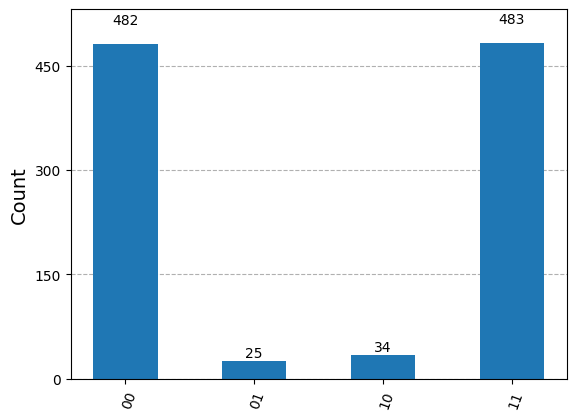

In [10]:
qvis.plot_histogram(pub_result.data["c"].get_counts())

### Now we can replicate the noise in the simulator. 
we get the configuration from real backend and pass the configuration to the simulator.

In [4]:
from qiskit_aer.noise import NoiseModel

n_model = NoiseModel.from_backend(ibm_backend)

coupling_map = ibm_backend.configuration().coupling_map

basis_gates = n_model.basis_gates

NameError: name 'ibm_backend' is not defined

In [12]:
res = v_backend.run(qc, coupling_map=coupling_map, basis_gates=basis_gates, noise_model=n_model).result()

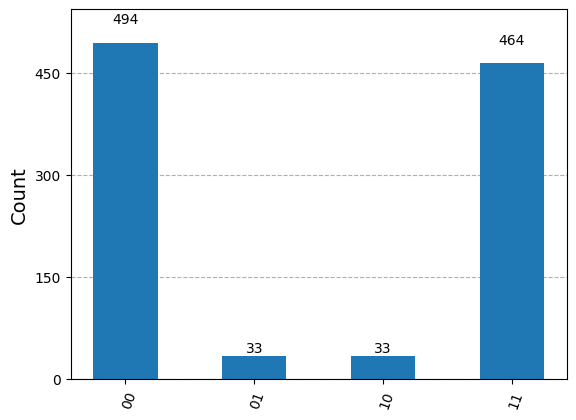

In [13]:
qvis.plot_histogram(res.get_counts())

### $T_1$ and $T_2$

Decoherence: loss of quantum coherence dur to a quantum system's pythsical interaction with its environment. Thie effects each qubit in many varying ways, one of which is when each qubit starts in a `|0>` ground state, and we operate on the qubit to move it from the `|0>` state to the `|1>` state.

the time required to change from the excited state to the grounded state is called the energy relaxation time denoted by $T_1$

$T_1$ is the time constant of the longitudinal loss (oriented along the z axis) of the singal intensity.

$T_2$ Dephasing where the phase information spreads out across widely so that the phase information is lost. For ex. if the qubit has `|+>` state the dephasing time is a decay constant time where the initial state decays down to a mixed state of `|+>` and `|->` where it is difficult to predict the state of the system.

$T_1$ to measure you need to apply a series of pulses seperated by a fixed time delay and capture the statistical results of the state as it moves from `|0>` to `|1>`. **Rabi oscillations` are generally used to provide the pulses that are then measured over time

$T_2$ to measure you would set the state of the qubit to `|+>` or `|->` and then applpy $\pi$ pulses at particular sequences to apply a phase roation. After applying a particular sequence of pulses over time the state should return to its original position that is `|+>` or `|->`. if dephasing occurs then the result will have a lower probabiity of returning to its original starting position. This technique of measuring $T_2$ is called **spin echo**.

Sources:
- Intrinsic noise often regarded as generic in nature, originates from sources within the system such as temp, or defects within the system so essentially materials or defects.
- Extrinsic noise originates from environmentally coupled systems such as wave interference, vibrations, Electromagnetic fields, ...

{'01': 13, '11': 491, '10': 15, '00': 505}


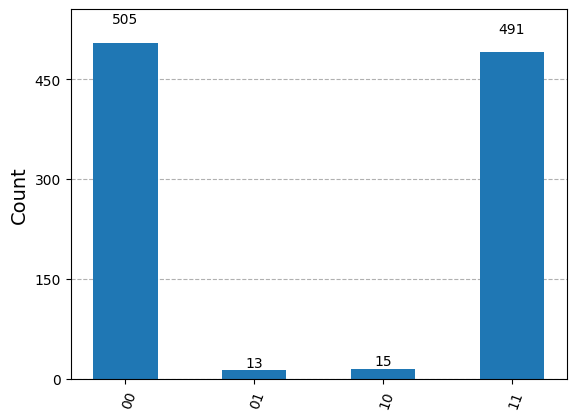

In [112]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error
from qiskit.visualization import plot_histogram

# Set T1 and T2 values (in microseconds)
t1 = 12.5  # 12.5 μs
t2 = 2.5   # 2.5 μs (should be <= t1)

# Gate times (in microseconds)
gate_time = 0.1  # 100 ns

# Create thermal relaxation error for each gate
t_err = thermal_relaxation_error(t1, t2, gate_time)

# Create noise model
noise_model = NoiseModel()

# Add errors to all gates on all qubits
noise_model.add_all_qubit_quantum_error(t_err, ['id', 'u1', 'u2', 'u3', 'x', 'sx', 'rz'])

# Add a specific error for the cx gate (which takes longer)
cx_gate_time = 0.3  # 300 ns
cx_err = thermal_relaxation_error(t1, t2, cx_gate_time).tensor(
    thermal_relaxation_error(t1, t2, cx_gate_time))
noise_model.add_all_qubit_quantum_error(cx_err, ['cx'])

# Create Bell state circuit
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure(range(2), range(2))

# Run with noise model
simulator = AerSimulator()
result = simulator.run(qc, noise_model=noise_model, shots=1024).result()
counts = result.get_counts()

# Plot results
print(counts)
plot_histogram(counts)

> [!NOTE]
> not sure why the thermal example not working as expected as 75 25 and higher number for 00 state

### single gate, multi gate, readout errors

single gate error, multi gate errors : generally happen when a qubit is operated upoon by the various gates on the system.
these errors are based on prababilities that the gate applied to the qubit doesn't work as expected
for example 5% gate error to a single qubit gate like NOT then the result of the operation has a 5% prob of not resulting in expected value.

readout error whappens when a measurement and acquisition is triggered to read out the value of the qubit.

### Custom noise model

In [117]:
from qiskit_aer.noise import depolarizing_error, ReadoutError

# Single and multi qubit proability error
single_qubit_gate_p = 0.25
multi_qubit_gate_p = 0.1

single_error = depolarizing_error(single_qubit_gate_p, 1)
multi_error = depolarizing_error(multi_qubit_gate_p, 2)

In [118]:
n_m = NoiseModel()
n_m.add_all_qubit_quantum_error(single_error, ['u2'])
n_m.add_all_qubit_quantum_error(multi_error, ['cx'])

In [119]:
print(n_m)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2']
  Instructions with noise: ['u2', 'cx']
  All-qubits errors: ['u2', 'cx']


classical readout errors are specified by a list of assignment probabilities vectors:

`P(A|B)` where A is the recorded classicial bit value and B is the true bit value returned from the measurement.
eqaution for a single qubit readout probability vector
$$
P(A|B) = \begin{pmatrix}
    P(A|0) & P(A|1)
\end{pmatrix}
$$


In [121]:
# probability of 0 given 1 as 0.7 and probability of 1 given 0 as 0.2
p0_1 = 0.7
p1_0 = 0.3

p0 = 1 - p0_1
p1 = 1 - p1_0
readout_error = ReadoutError([[p0_1, p1_0], [p0, p1]])
n_m.add_readout_error(readout_error, [0])
print(n_m)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2']
  Instructions with noise: ['measure', 'u2', 'cx']
  Qubits with noise: [0]
  All-qubits errors: ['u2', 'cx']
  Specific qubit errors: [('measure', (0,))]


In [123]:
qc_error = QuantumCircuit(2,2)
qc_error.h(0)
qc_error.cx(0,1)
qc_error.measure(range(2), range(2))
qc_error.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

In [128]:
res = QasmSimulator().run(qc_error, basis_gates=n_m.basis_gates, noise_model=n_m).result()

In [129]:
res.get_counts()

{'11': 336, '01': 159, '00': 355, '10': 174}

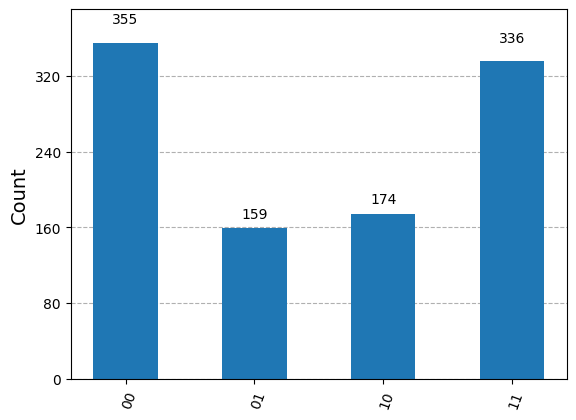

In [130]:
qvis.plot_histogram(res.get_counts())

After Applying Depolarizing Noise:

    With probability 1−p, the state remains unchanged.

    With probability p, the state randomly changes to |0⟩, |1⟩, |+⟩, |−⟩, etc.

    This pulls the state towards the center of the Bloch sphere.

Depolarizing Noise Effect

    With some probability pp, the state gets randomly replaced by a completely mixed state.

    This means the sharp arrow becomes shorter and more diffused, losing coherence.

    Visually, the Bloch sphere representation becomes blurred as the state drifts toward the center.